## BERT Model

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('final_150_words.csv')
df

,label,type,clean_content
0,1,reliable,"Healthcare | Wed Nov 0, 0 | 0:0am EST BRIEF-Pl..."
1,1,reliable,Kristina Stewart and Arthur Burton Ward were m...
2,0,fake,The Chairman’s Blog % of readers think this st...
3,1,reliable,Mia Hamm and her longtime teammate Julie Foudy...
4,0,fake,Saul via John Smallman: The Vast Majority of H...
...,...,...,...
19995,1,reliable,"“Santa delivers the goods.” Ken Perkins, presi..."
19996,1,reliable,"GOLDSMITH--S. Delvalle, born March 0, 0, passe..."
19997,0,fake,The Video Every YouTuber and Viewer Needs to S...
19998,0,fake,MagaPillQ -- President Trump Just Tweeted Out ...


In [18]:
import numpy as np
contents = [content for content in df.clean_content]

max_content_len = 0

content_len = []
for content in contents:
    content_len.append(len(content.split()))
    max_content_len = max(len(content.split()), max_content_len)

print('Number of contents:', len(contents))
print('Max length of the contents:', max_content_len)
print('Mean length of the contents:', np.mean(content_len))

Number of contents: 20000
Max length of the contents: 150
Mean length of the contents: 75.2291


### Model and Training

In [4]:
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                           attention_probs_dropout_prob = 0.2,
                                                            num_labels=2)  #  binary classification (fake/real)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
bert_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.2,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.37.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [6]:
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

class FakeNewsDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=150):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['clean_content']
        label = torch.tensor(self.data.iloc[idx]['label'], dtype=torch.long)

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            padding='max_length',
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()

        return {'input_ids': input_ids, 'attention_mask': attention_mask, 'label': label}

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = bert_model

# model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Create datasets and data loaders
train_dataset = FakeNewsDataset(train_df, tokenizer)
val_dataset = FakeNewsDataset(val_df, tokenizer)
test_dataset = FakeNewsDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
NUM_EPOCHS = 10
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []
test_accuracies = []

for epoch in range(NUM_EPOCHS):
    # Training
    model.train()
    train_loss = 0.0
    all_preds = []
    all_labels = []

    loop = tqdm(train_loader)
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs.logits, 1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

        train_loss += loss.item()

        loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=train_loss / len(loop), acc=accuracy_score(all_preds, all_labels))

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            _, preds = torch.max(outputs.logits, 1)

            val_preds.extend(preds.cpu().tolist())
            val_labels.extend(labels.cpu().tolist())

            val_loss += loss.item()

# training 
    model.eval()
    test_loss = 0.0
    all_test_preds = []
    all_test_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            _, test_preds = torch.max(outputs.logits, 1)

            all_test_preds.extend(test_preds.tolist())
            all_test_labels.extend(labels.tolist())

            test_loss += loss.item()

    test_accuracy = accuracy_score(all_test_labels, all_test_preds)
    test_accuracies.append(test_accuracy)

    train_acc = accuracy_score(all_preds, all_labels)
    val_acc = accuracy_score(val_preds, val_labels)

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_acc)
    train_accuracies.append(train_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [1/10] - Training Accuracy: 0.9453, Validation Accuracy: 0.9605


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [2/10] - Training Accuracy: 0.9806, Validation Accuracy: 0.9760


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [3/10] - Training Accuracy: 0.9896, Validation Accuracy: 0.9790


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [4/10] - Training Accuracy: 0.9952, Validation Accuracy: 0.9810


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [5/10] - Training Accuracy: 0.9978, Validation Accuracy: 0.9825


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [6/10] - Training Accuracy: 0.9978, Validation Accuracy: 0.9805


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [7/10] - Training Accuracy: 0.9985, Validation Accuracy: 0.9830


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [8/10] - Training Accuracy: 0.9981, Validation Accuracy: 0.9695


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [9/10] - Training Accuracy: 0.9976, Validation Accuracy: 0.9845


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch [10/10] - Training Accuracy: 0.9986, Validation Accuracy: 0.9830


In [7]:
torch.save(model, 'best_bert_model.pth')
print('model_saved')

model_saved


### Plotting Training and Validation Accuracy

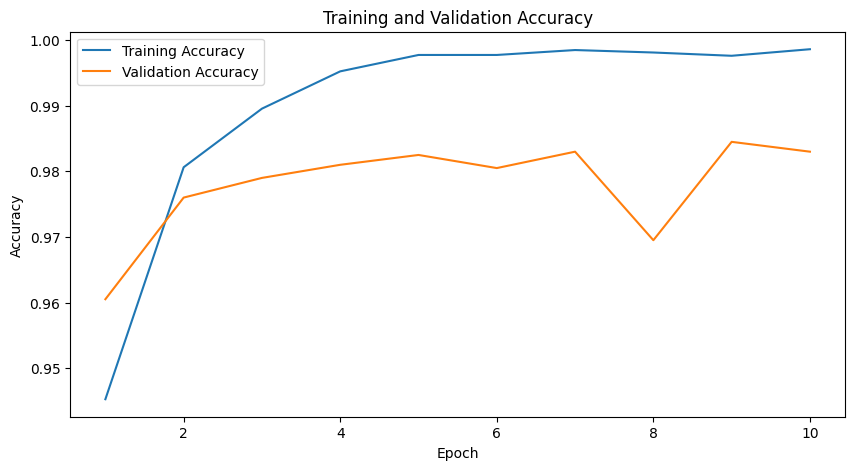

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Y axis is started not from 0.

### Plotting the Training and Validation loss 

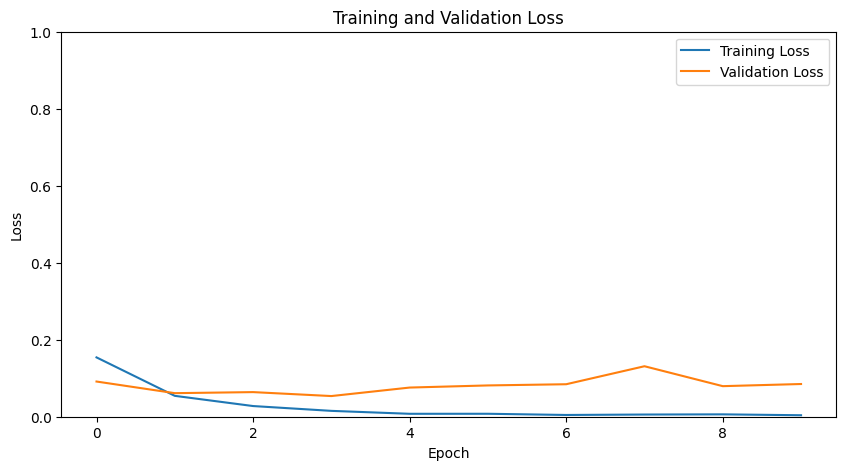

In [9]:

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.ylim(0,1)
plt.legend()
plt.show()


In [16]:
from sklearn.metrics import classification_report

class_report = classification_report(all_test_labels, all_test_preds, target_names=['Fake', 'Real'])
print(class_report)

              precision    recall  f1-score   support

        Fake       0.98      0.97      0.98       951
        Real       0.97      0.98      0.98      1049

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



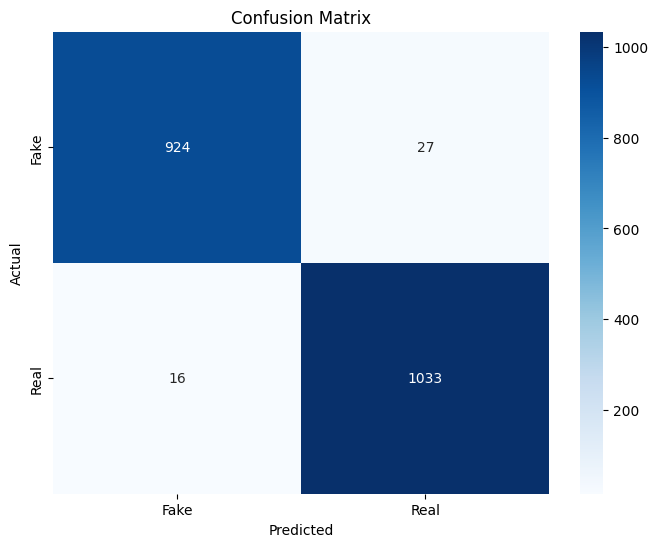

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(all_test_labels, all_test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Test Accuracy

In [11]:
model_checkpoint = "best_bert_model.pth"
model = torch.load(model_checkpoint)
model = model.to(device)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

test_train_accuracies = []

def calculate_accuracy(data_loader, test_model):
    test_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = test_model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

test_accuracy = calculate_accuracy(test_loader, model)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9785


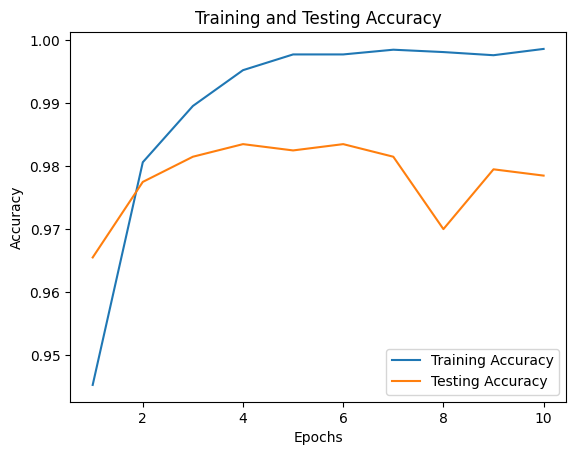

In [12]:
epochs = range(1, NUM_EPOCHS + 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

Y axis is started not from 0.

In [13]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,